02:08:03 - cmdstanpy - INFO - Chain [1] start processing
02:08:03 - cmdstanpy - INFO - Chain [1] done processing


      id_клиента  Purchase Count                  Group
0        id00001               5  Постоянные покупатели
1        id00002               5  Постоянные покупатели
2        id00003               5  Постоянные покупатели
3        id00004               4  Постоянные покупатели
4        id00005               3           Нерегулярные
...          ...             ...                    ...
25347    id60032               1                Разовые
25348    id60037               1                Разовые
25349    id60039               1                Разовые
25350    id60040               1                Разовые
25351    id60046               1                Разовые

[25352 rows x 3 columns]


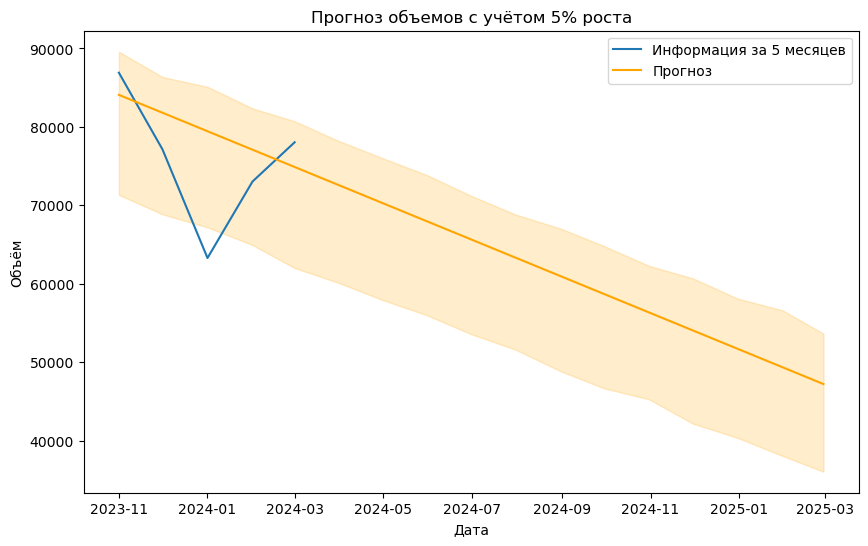

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

df = pd.read_excel('book2.xlsx')
df['yyyy_mm'] = pd.to_datetime(df['yyyy_mm'])
monthly_volume = df.groupby(df['yyyy_mm'].dt.to_period('M')).agg({'Объем': 'sum'}).reset_index()
monthly_volume['yyyy_mm'] = monthly_volume['yyyy_mm'].dt.to_timestamp()
monthly_volume.to_csv('original_data_for_PBI.csv', index=False)

client_purchase_counts = df.groupby('id_клиента').size().reset_index(name='Purchase Count')
conditions = [
    (client_purchase_counts['Purchase Count'] >= 4),
    (client_purchase_counts['Purchase Count'] >= 2) & (client_purchase_counts['Purchase Count'] <= 3),
    (client_purchase_counts['Purchase Count'] == 1)
]
choices = ['Разовые', 'Нерегулярные', 'Постоянные покупатели']
client_purchase_counts['Group'] = pd.cut(client_purchase_counts['Purchase Count'], bins=[0, 1, 3, 5], labels=choices, right=True)
client_purchase_counts.to_csv('test_task_grouped_clients.csv', index=False)
print(client_purchase_counts)

#теперь прогноз на профете, если у вас не этой библиотеки то просто можете посмотреть плот ниже
prophet_df = monthly_volume[['yyyy_mm', 'Объем']].rename(columns={'yyyy_mm': 'ds', 'Объем': 'y'})
model = Prophet()
model.fit(prophet_df)
future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)
forecast['yhat'] *= 1.05
#print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])
forecast.to_csv('forecast.csv', index=False)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(prophet_df['ds'], prophet_df['y'], label='Информация за 5 месяцев')
ax.plot(forecast['ds'], forecast['yhat'], label='Прогноз', color='orange')
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='orange', alpha=0.2)
ax.set_title('Прогноз объемов с учётом 5% роста')
ax.set_xlabel('Дата')
ax.set_ylabel('Объём')
ax.legend()
plt.savefig("forecast.png")
plt.show()
